In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns   
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 

/Applications/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Applications/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [5]:
from sklearn.model_selection import cross_val_score 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LassoCV

In [379]:
df= pd.read_csv("V-Dem-CY-FullOthers-v15_csv (1)/V-Dem-CY-Full+Others-v15.csv")

In [380]:
df.shape

(27913, 4607)

In [381]:
df.head(5)

,country_name,country_text_id,country_id,year,historical_date,project,historical,histname,codingstart,codingend,...,e_mipopula,e_miurbani,e_pefeliex,e_wb_pop,e_pechmor,e_miinteco,e_civil_war,e_miinterc,e_pt_coup,e_pt_coup_attempts
0,Mexico,MEX,3,1789,1789-12-31,1,1,Viceroyalty of New Spain,1789,2024,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
1,Mexico,MEX,3,1790,1790-12-31,1,1,Viceroyalty of New Spain,1789,2024,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
2,Mexico,MEX,3,1791,1791-12-31,1,1,Viceroyalty of New Spain,1789,2024,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
3,Mexico,MEX,3,1792,1792-12-31,1,1,Viceroyalty of New Spain,1789,2024,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
4,Mexico,MEX,3,1793,1793-12-31,1,1,Viceroyalty of New Spain,1789,2024,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN


In [382]:
df['dup'] = df.duplicated(subset=['country_id', 'year'], keep=False).astype(int)
dup_count = df['dup'].sum()

In [383]:
print(f"Number of rows flagged as duplicates: {dup_count}")
print(f"Percentage of duplicated rows: {dup_count/len(df)*100:.2f}%")

Number of rows flagged as duplicates: 0
Percentage of duplicated rows: 0.00%


In [384]:
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)
print(missing_percent)

v3elupvtsm       99.989252
v3elupvtlg       99.989252
v3eltvriguc      99.935514
v3elageuc        99.931931
v3elupstsl       99.738473
                   ...    
v2x_elecreg       0.032243
v2xex_elecreg     0.032243
v2exhoshog        0.032243
v2xlg_elecreg     0.032243
v2svindep         0.003583
Length: 4586, dtype: float64


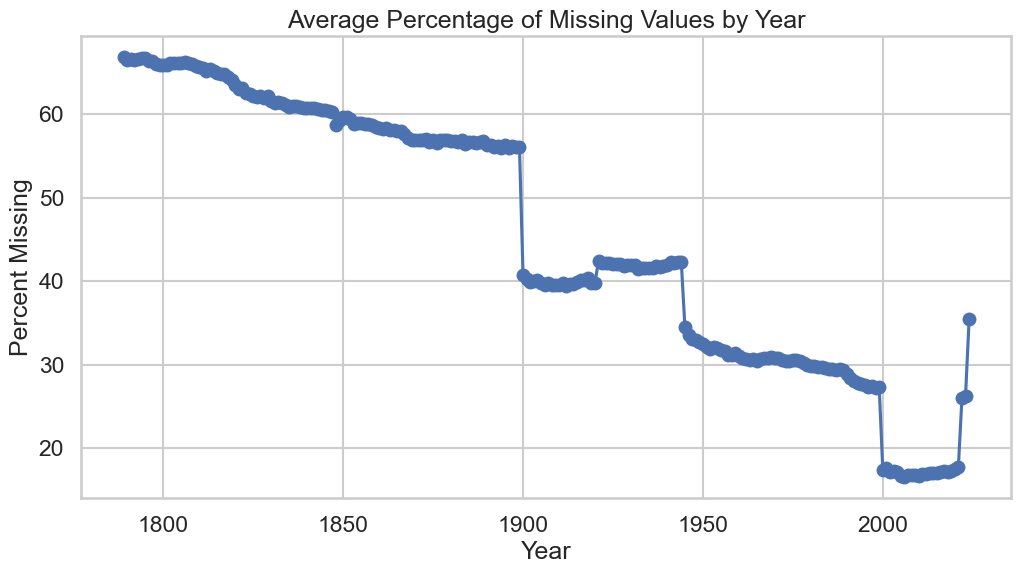

In [385]:
# Analyze missing data over time  

missing_by_year = df.groupby('year').apply(lambda x: x.isnull().mean() * 100)

# Overall missingness by year (averaged across all variables) 

yearly_missingness = missing_by_year.mean(axis=1).sort_index()

# Plot the trend of missing values over time   

plt.figure(figsize=(12, 6))
yearly_missingness.plot(marker='o')
plt.title('Average Percentage of Missing Values by Year')
plt.xlabel('Year')
plt.ylabel('Percent Missing')
plt.grid(True)
plt.show()

Due to very high missing values in the dataset we want to focus after 1950 because the percentage of missing values in the dataset declined after that.

# Drop the variables with more than 70% missing values 

In [386]:
df_modern = df[df["year"] > 1970]

In [387]:
df_modern.head(5)

,country_name,country_text_id,country_id,year,historical_date,project,historical,histname,codingstart,codingend,...,e_miurbani,e_pefeliex,e_wb_pop,e_pechmor,e_miinteco,e_civil_war,e_miinterc,e_pt_coup,e_pt_coup_attempts,dup
182,Mexico,MEX,3,1971,1971-12-31,0,1,United Mexican States,1789,2024,...,0.533,64.317,51897675.0,103.98,0.0,0.0,0.0,0.0,0.0,0
183,Mexico,MEX,3,1972,1972-12-31,0,1,United Mexican States,1789,2024,...,0.534,64.944,53543436.0,100.20,0.0,0.0,0.0,0.0,0.0,0
184,Mexico,MEX,3,1973,1973-12-31,0,1,United Mexican States,1789,2024,...,0.535,65.571,55228203.0,96.57,0.0,0.0,0.0,0.0,0.0,0
185,Mexico,MEX,3,1974,1974-12-31,0,1,United Mexican States,1789,2024,...,0.536,66.198,56945880.0,93.19,0.0,0.0,0.0,0.0,0.0,0
186,Mexico,MEX,3,1975,1975-12-31,0,1,United Mexican States,1789,2024,...,0.537,66.825,58691882.0,89.99,0.0,0.0,0.0,0.0,0.0,0


# List of countries to filter  

eu_countries = [
   'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 
   'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 
   'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 
   'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden'
]

selected_countries = eu_countries + ['United States of America', 'Switzerland', 'United Kingdom']

# Filter the dataframe for selected countries 

df_selected = df[df['country_name'].isin(selected_countries)].copy()

In [388]:
df_2 = pd.read_csv("gdp_data/gdp_1.csv")

In [389]:
gdp_data = df_2[df_2['Item'] == 'Gross Domestic Product (GDP)']

In [390]:
gdp_data = gdp_data.rename(columns={'Country or Area': 'country_name'})

In [391]:
gdp_data = gdp_data.rename(columns={'Year': 'year'})

In [392]:
gdp_data = gdp_data.rename(columns={'Value': 'gdp'})

In [393]:
gdp_data = gdp_data.drop(columns=['Item'])

In [394]:
df = df[df["year"] > 1970]

In [395]:
merged_df = pd.merge(df, gdp_data, on=['country_name', 'year'], how='left', validate='one_to_one') 

In [396]:
merged_df.head(5)

,country_name,country_text_id,country_id,year,historical_date,project,historical,histname,codingstart,codingend,...,e_pefeliex,e_wb_pop,e_pechmor,e_miinteco,e_civil_war,e_miinterc,e_pt_coup,e_pt_coup_attempts,dup,gdp
0,Mexico,MEX,3,1971,1971-12-31,0,1,United Mexican States,1789,2024,...,64.317,51897675.0,103.98,0.0,0.0,0.0,0.0,0.0,0,3.037328e+11
1,Mexico,MEX,3,1972,1972-12-31,0,1,United Mexican States,1789,2024,...,64.944,53543436.0,100.20,0.0,0.0,0.0,0.0,0.0,0,3.295132e+11
2,Mexico,MEX,3,1973,1973-12-31,0,1,United Mexican States,1789,2024,...,65.571,55228203.0,96.57,0.0,0.0,0.0,0.0,0.0,0,3.572222e+11
3,Mexico,MEX,3,1974,1974-12-31,0,1,United Mexican States,1789,2024,...,66.198,56945880.0,93.19,0.0,0.0,0.0,0.0,0.0,0,3.790512e+11
4,Mexico,MEX,3,1975,1975-12-31,0,1,United Mexican States,1789,2024,...,66.825,58691882.0,89.99,0.0,0.0,0.0,0.0,0.0,0,4.003201e+11


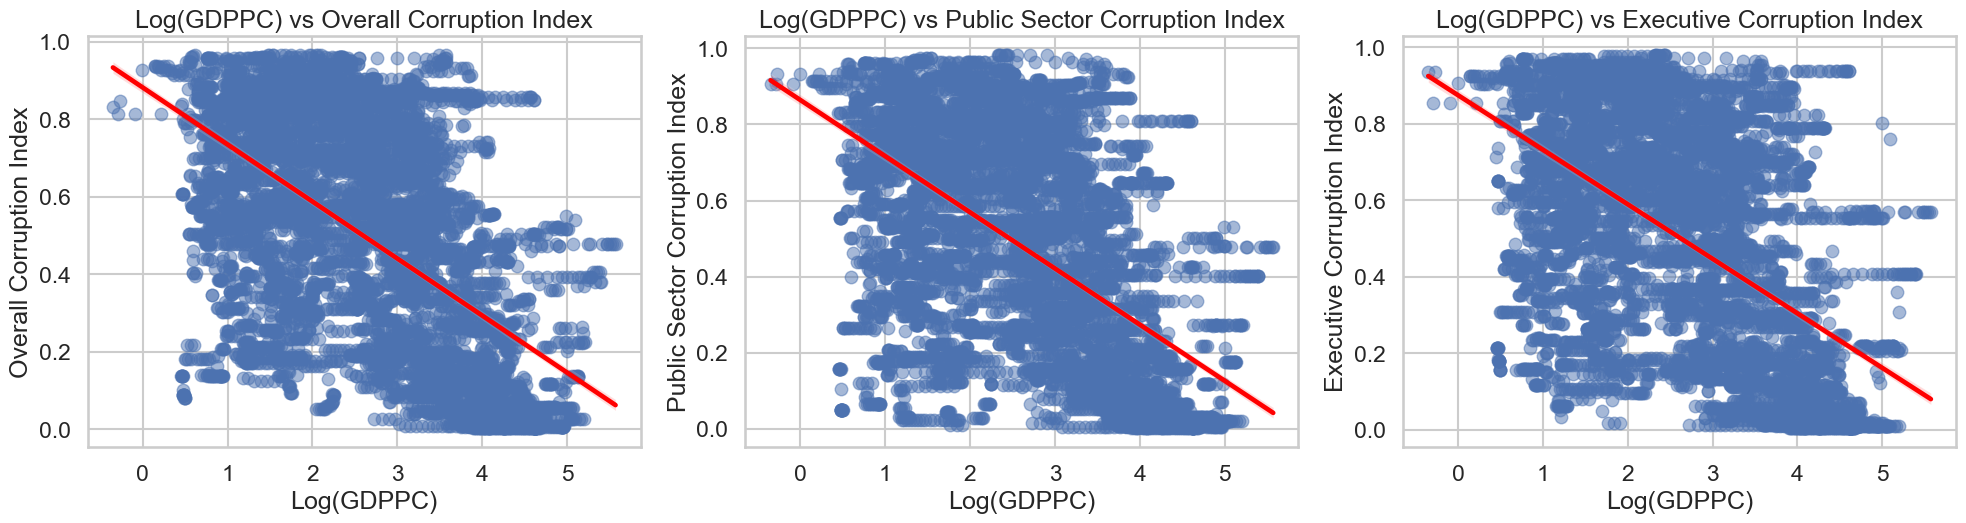

In [397]:
# Comprehensive list of corruption variables
corruption_vars = {
    'v2x_corr': 'Overall Corruption Index',
    'v2x_pubcorr': 'Public Sector Corruption Index', 
    'v2x_execorr': 'Executive Corruption Index',
}

# Create a multi-plot figure
plt.figure(figsize=(20, 15))

# Create subplots for each corruption variable
for i, (var, label) in enumerate(corruption_vars.items(), 1):
    plt.subplot(3, 3, i)
    
    # Scatter plot with regression line
    sns.regplot(
        x=np.log(merged_df['e_gdppc']), 
        y=var, 
        data=merged_df, 
        scatter_kws={'alpha':0.5}, 
        line_kws={'color':'red'}
    )
    
    plt.xlabel('Log(GDPPC)')
    plt.ylabel(label)
    plt.title(f'Log(GDPPC) vs {label}')

plt.tight_layout()
plt.show()


## Selecting the variables 

In [398]:
cols_to_drop = [col for col in cleaned_dataset.columns 
                if (col.endswith('_osp') or
                    col.endswith('_ord') or
                    col.endswith('codelow') or
                    col.endswith('codehigh') or
                    '_sd' in col or
                    col.endswith('_mean') or
                    col.endswith('_nr'))] 

In [399]:
cleaned_dataset = df_subset.drop(columns=cols_to_drop)

In [400]:
cleaned_dataset.shape

(9193, 1082)

In [401]:
cleaned_dataset.head(3)

,gapstart2,gapend2,v2x_polyarchy,v2x_polyarchy_codelow,v2x_polyarchy_codehigh,v2x_libdem,v2x_libdem_codelow,v2x_libdem_codehigh,v2x_partipdem,v2x_partipdem_codelow,...,e_uds_pct975,e_ti_cpi,e_vanhanen,e_peaveduc,e_gdppc,e_pefeliex,country_name,country_id,country_text_id,year
182,NaN,NaN,0.246,0.223,0.266,0.107,0.089,0.125,0.144,0.127,...,-0.115,NaN,3.9,4.503,16.679,64.317,Mexico,3,MEX,1971
183,NaN,NaN,0.249,0.225,0.270,0.109,0.088,0.123,0.146,0.129,...,-0.045,NaN,3.9,4.616,17.403,64.944,Mexico,3,MEX,1972
184,NaN,NaN,0.249,0.224,0.270,0.109,0.090,0.126,0.146,0.129,...,-0.017,NaN,3.9,4.729,18.222,65.571,Mexico,3,MEX,1973


In [402]:
def visualize_missing_data(df):
    """
    Visualize missing data percentages for each column without showing variable names.
    Uses thicker bars with deeper color.
    
    Parameters:
    -----------
    df : pandas DataFrame
        Input dataset
    """
    # Calculate missing percentage
    missing_percentage = df.isnull().mean() * 100
    
    # Check if there are any missing values at all
    if missing_percentage.max() == 0:
        print("No missing values found in the dataset.")
        return
    
    # Sort values for better visualization (exclude columns with no missing values)
    missing_sorted = missing_percentage[missing_percentage > 0].sort_values(ascending=False)
    
    # Check if there are any columns with missing values after filtering
    if len(missing_sorted) == 0:
        print("No missing values found in the dataset.")
        return
    
    # Plot missing percentage as a bar chart with thicker bars and deeper color
    plt.figure(figsize=(15, 6))
    plt.bar(range(len(missing_sorted)), missing_sorted.values, 
            color='#1E3D59',  # Deep blue color
            edgecolor='blue',
            linewidth=1.2,
            width=0.8)  # Make bars thicker
            
    plt.title('Percentage of Missing Values per Column', fontsize=14, fontweight='bold')
    plt.xlabel('Variables (sorted by missing percentage)', fontsize=12)
    plt.ylabel('Missing Percentage (%)', fontsize=12)
    
    # Hide x-axis labels (column names) as requested
    plt.xticks([])
    
    # Add grid lines for easier reading of values
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Set y-axis to start from 0 and go slightly above the maximum percentage
    plt.ylim(0, min(100, missing_sorted.max() * 1.1))
    
    # Add summary text
    plt.figtext(0.15, 0.85, 
                f"Columns with missing values: {len(missing_sorted)}/{len(df.columns)}\n"
                f"Max missing: {missing_sorted.iloc[0]:.1f}%", 
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round', pad=0.5))
    
    plt.tight_layout()
    plt.show()

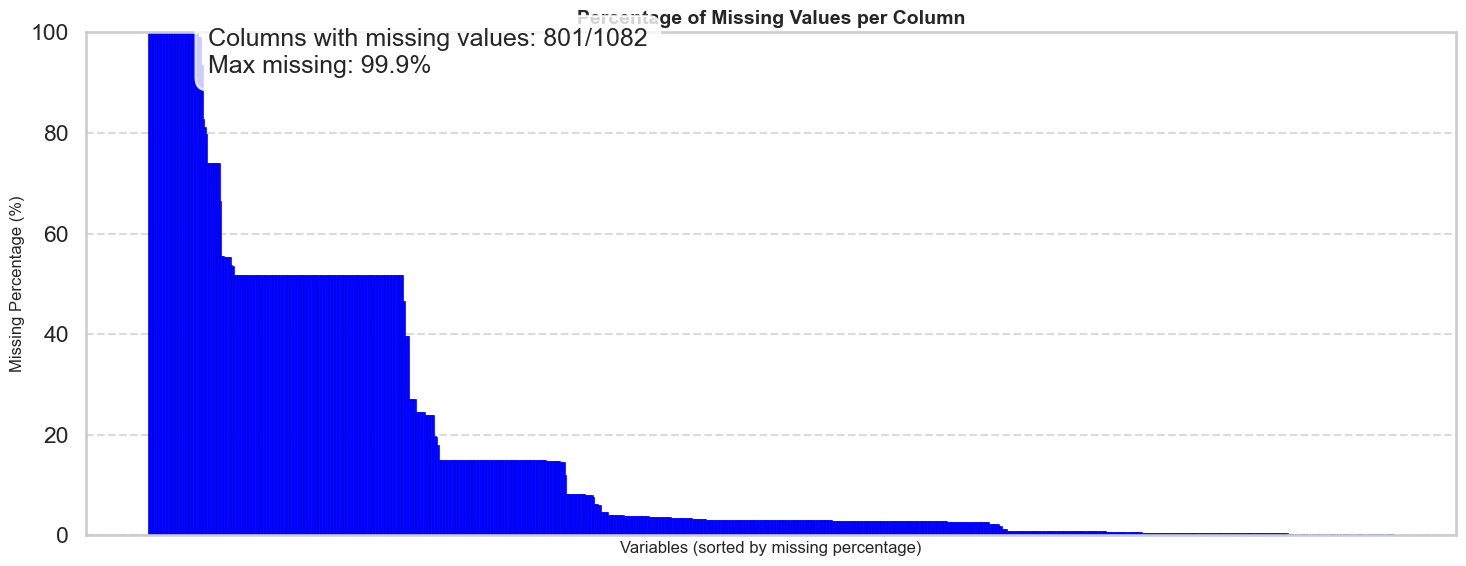

In [403]:
visualize_missing_data(cleaned_dataset)

In [404]:
def drop_high_missing_variables(df, threshold=0.80):
    """
    Drop variables with more than specified percentage of missing values
    
    Parameters:
    -----------
    df : pandas DataFrame
        Input dataset
    threshold : float, optional (default=0.7)
        Threshold for missing values (70% in this case)
    
    Returns:
    --------
    cleaned_df : pandas DataFrame
        DataFrame with high-missing columns removed
    dropped_columns : list
        List of dropped columns
    """
    # Calculate missing percentage for each column
    missing_percentages = df.isnull().mean()
    
    # Identify columns to drop
    columns_to_drop = missing_percentages[missing_percentages > threshold].index.tolist()
    
    # Create a copy of the dataframe and drop identified columns
    cleaned_df = df.drop(columns=columns_to_drop)
    
    # Print dropped columns and their missing percentages
    print("\nDropped Columns:")
    for col in columns_to_drop:
        print(f"{col}: {missing_percentages[col]*100:.2f}% missing")
    
    print(f"\nTotal columns dropped: {len(columns_to_drop)}")
    print(f"Remaining columns: {cleaned_df.shape[1]}")
    
    return cleaned_df, columns_to_drop 

In [405]:
cleaned_dataset, dropped_vars = drop_high_missing_variables(cleaned_dataset)


Dropped Columns:
gapstart2: 98.83% missing
gapend2: 98.83% missing
v2ddcredal: 93.36% missing
v3elbalstat_codelow: 99.88% missing
v3elbalstat_codehigh: 99.88% missing
v3elecsedf: 99.88% missing
v3elecsedf_codelow: 99.88% missing
v3elecsedf_codehigh: 99.88% missing
v3elecsedf_sd: 99.88% missing
v3elecsedf_osp: 99.88% missing
v3elecsedf_osp_codelow: 99.88% missing
v3elecsedf_osp_codehigh: 99.88% missing
v3elecsedf_osp_sd: 99.88% missing
v3elcomvot: 99.88% missing
v3elcomvot_codelow: 99.88% missing
v3elcomvot_codehigh: 99.88% missing
v3elcomvot_sd: 99.88% missing
v3elcomvot_osp: 99.88% missing
v3elcomvot_osp_codehigh: 99.88% missing
v3elcomvot_osp_sd: 99.88% missing
v3ststeecap: 99.75% missing
v3ststeecap_codehigh: 99.75% missing
v3ststeecap_sd: 99.75% missing
v3ststeecap_osp: 99.75% missing
v3ststeecap_osp_codelow: 99.75% missing
v3lgcrrpt: 99.77% missing
v3lgcrrpt_codelow: 99.77% missing
v3lgcrrpt_codehigh: 99.77% missing
v3lgcrrpt_sd: 99.77% missing
v3lgcrrpt_osp: 99.77% missing
v3lgc

In [406]:
print(f"Number of missing values: {cleaned_dataset['v2x_corr'].isna().sum()}")

Number of missing values: 64


In [407]:
cleaned_dataset = cleaned_dataset.dropna(subset=['v2x_corr'])

In [408]:
cleaned_dataset.head(5)

,v2x_polyarchy,v2x_polyarchy_codelow,v2x_polyarchy_codehigh,v2x_libdem,v2x_libdem_codelow,v2x_libdem_codehigh,v2x_partipdem,v2x_partipdem_codelow,v2x_partipdem_codehigh,v2x_delibdem,...,e_uds_pct975,e_ti_cpi,e_vanhanen,e_peaveduc,e_gdppc,e_pefeliex,country_name,country_id,country_text_id,year
182,0.246,0.223,0.266,0.107,0.089,0.125,0.144,0.127,0.158,0.125,...,-0.115,NaN,3.9,4.503,16.679,64.317,Mexico,3,MEX,1971
183,0.249,0.225,0.270,0.109,0.088,0.123,0.146,0.129,0.161,0.125,...,-0.045,NaN,3.9,4.616,17.403,64.944,Mexico,3,MEX,1972
184,0.249,0.224,0.270,0.109,0.090,0.126,0.146,0.129,0.160,0.125,...,-0.017,NaN,3.9,4.729,18.222,65.571,Mexico,3,MEX,1973
185,0.249,0.226,0.272,0.108,0.092,0.128,0.146,0.128,0.160,0.126,...,-0.013,NaN,3.9,4.842,19.023,66.198,Mexico,3,MEX,1974
186,0.249,0.226,0.272,0.108,0.090,0.125,0.146,0.128,0.160,0.126,...,-0.006,NaN,3.9,4.955,19.761,66.825,Mexico,3,MEX,1975


In [409]:
def fill_missing_values_vdem(df):
    """
    Fill missing values in V-Dem dataset based on specific rules:
    1. For election variables when elections are permitted: carry forward last non-missing value
    2. For election variables when elections not permitted or interrupted: set to zero and create indicator
    3. For legislative variables during interruption: set to zero and create indicator
    4. For legislative variables in first year of viable legislative branch: back-fill
    
    Parameters:
    -----------
    df : pandas DataFrame
        Input V-Dem dataset
    
    Returns:
    --------
    df_filled : pandas DataFrame
        Dataset with missing values filled according to rules
    """
    # Make a copy to avoid modifying the original dataframe
    df_filled = df.copy()
    
    # Step 1: Identify election-related variables
    # These typically include variables with 'el' in their name
    election_vars = [col for col in df.columns if 'el' in col.lower() and df[col].dtype != 'object']
    
    # Step 2: Identify legislative-related variables
    # These typically include variables with 'lg' in their name
    legislative_vars = [col for col in df.columns if 'lg' in col.lower() and df[col].dtype != 'object']
    
    # Create new columns to track whether values were imputed
    for col in election_vars:
        df_filled[f"{col}_imputed"] = 0
        
    for col in legislative_vars:
        df_filled[f"{col}_imputed"] = 0
    
    # Step 3: Process country by country (and sort by year)
    countries = df_filled['country_id'].unique()
    
    for country in countries:
        # Get data for this country and sort by year
        country_data = df_filled[df_filled['country_id'] == country].sort_values('year')
        country_idx = country_data.index
        
        # Rule 1: For election variables when elections are permitted - carry forward
        for col in election_vars:
            # Forward fill (carries last non-missing value forward)
            filled_values = country_data[col].ffill()  # Using ffill() instead of fillna(method='ffill')
            df_filled.loc[country_idx, col] = filled_values
            
            # Mark which values were imputed
            imputed_mask = country_data[col].isna() & filled_values.notna()
            df_filled.loc[country_idx[imputed_mask], f"{col}_imputed"] = 1
            
        # Rule 4: For legislative variables in first year - backfill
        for col in legislative_vars:
            # Back fill for first year legislative variables
            filled_values = country_data[col].bfill()  # Using bfill() instead of fillna(method='bfill')
            df_filled.loc[country_idx, col] = filled_values
            
            # Mark which values were imputed
            imputed_mask = country_data[col].isna() & filled_values.notna()
            df_filled.loc[country_idx[imputed_mask], f"{col}_imputed"] = 1
    
    # Create indicator variables for election/legislative interruptions
    df_filled['elections_permitted'] = 1
    df_filled['legislature_active'] = 1
    
    # Rule 2: For election variables when elections not permitted or interrupted
    # We need to identify these cases - for this example, we'll assume that if all election
    # variables are missing for a specific year, elections were not permitted
    
    election_all_missing = df_filled[election_vars].isna().all(axis=1)
    df_filled.loc[election_all_missing, 'elections_permitted'] = 0
    
    # Set these values to 0
    for col in election_vars:
        still_missing = df_filled[col].isna()
        df_filled.loc[still_missing, col] = 0
        df_filled.loc[still_missing, f"{col}_imputed"] = 2  # Code 2 for "set to zero due to no elections"
    
    # Rule 3: For legislative variables during interruption 
    
    # Similar assumption: if all legislative variables are missing, legislature was interrupted
    
    legislative_all_missing = df_filled[legislative_vars].isna().all(axis=1)
    df_filled.loc[legislative_all_missing, 'legislature_active'] = 0
    
    # Set these values to 0
    for col in legislative_vars:
        still_missing = df_filled[col].isna()
        df_filled.loc[still_missing, col] = 0
        df_filled.loc[still_missing, f"{col}_imputed"] = 2  # Code 2 for "set to zero due to interruption"
    
    # Calculate and print summary of imputation
    print("Missing values summary before imputation:")
    print(f"Total missing values: {df.isna().sum().sum()}")
    print(f"Variables with missing values: {df.isna().any().sum()} / {len(df.columns)}")
    
    print("\nMissing values summary after imputation:")
    print(f"Total missing values: {df_filled.isna().sum().sum()}")
    print(f"Variables with missing values: {df_filled.isna().any().sum()} / {len(df_filled.columns)}")
    
    return df_filled 

In [410]:
df_filled = fill_missing_values_vdem(cleaned_dataset)

Missing values summary before imputation:
Total missing values: 863131
Variables with missing values: 605 / 1045

Missing values summary after imputation:
Total missing values: 512015
Variables with missing values: 320 / 1460


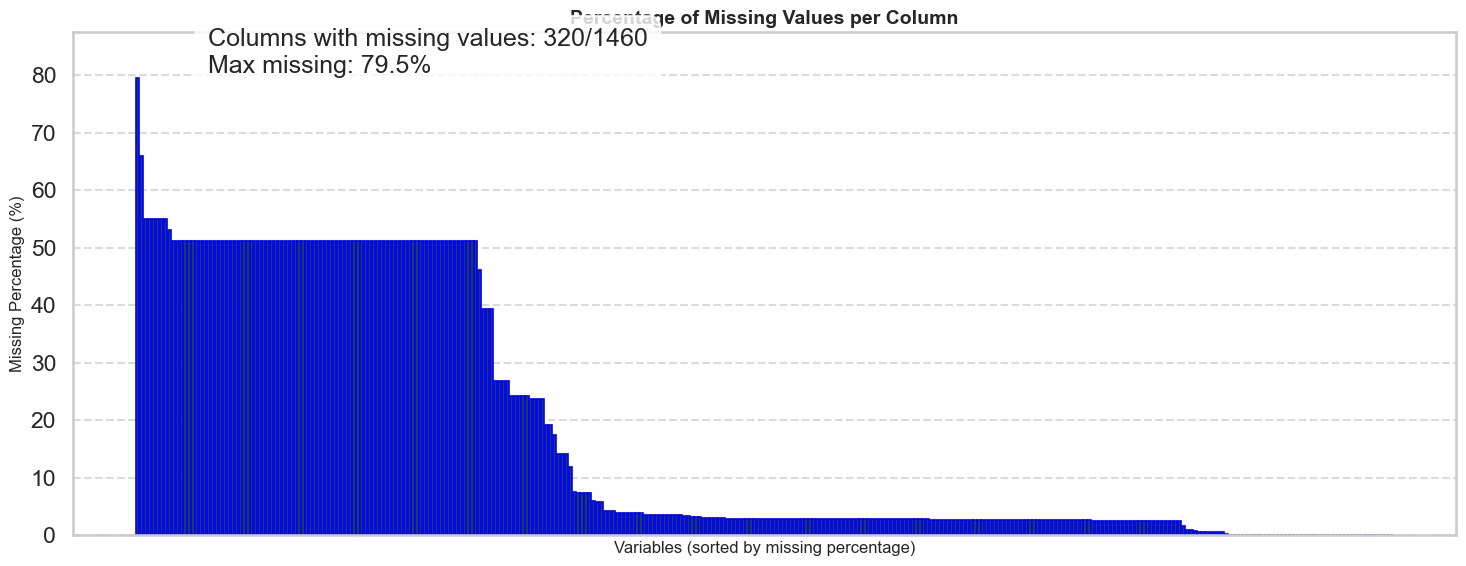

In [411]:
visualize_missing_data(df_filled)

In [412]:
from sklearn.ensemble import RandomForestRegressor

def impute_missing_by_group(df, group_col='country_id', max_features=0.5, n_estimators=100):
    """
    Impute missing values separately for each group (e.g., country).
    Will attempt to fill ALL missing values regardless of percentage.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataset with missing values
    group_col : str, default='country_id'
        The column to group by (typically country or region)
    max_features : float or int, default=0.5
        The number of features to consider for each split
    n_estimators : int, default=100
        The number of trees in the forest
        
    Returns:
    --------
    df_imputed : pandas DataFrame
        The dataset with imputed values
    """
    # Make a copy to avoid modifying the original
    df_imputed = df.copy()
    
    # Get unique groups
    groups = df[group_col].unique()
    
    print(f"Imputing data separately for {len(groups)} groups based on {group_col}")
    
    # Get columns with missing values
    cols_with_missing = [col for col in df.columns 
                         if df[col].isna().any() and np.issubdtype(df[col].dtype, np.number)]
    
    # Create tracking columns for imputed values
    for col in cols_with_missing:
        df_imputed[f"{col}_imputed_rf"] = df_imputed[col].isna().astype(int)
    
    # For each group
    for group in groups:
        print(f"\nProcessing group: {group}")
        
        # Get data for this group
        group_data = df_imputed[df_imputed[group_col] == group].copy()
        
        # Skip groups with too little data, but using lower threshold
        if len(group_data) < 5:  # Reduced from 10
            print(f"  Skipping group {group} - not enough data ({len(group_data)} rows)")
            continue
        
        # Identify columns with missing values for this group
        group_missing = [col for col in cols_with_missing if group_data[col].isna().any()]
        
        if not group_missing:
            print(f"  No missing values for group {group}")
            continue
            
        print(f"  Found {len(group_missing)} columns with missing values")
        
        # Proceed only with numeric columns for this group
        numeric_cols = group_data.select_dtypes(include=[np.number]).columns.tolist()
        
        # For each column with missing values
        for col_to_impute in group_missing:
            # No longer skipping columns with high missing percentage
            
            # Get rows with non-missing values for training
            train_data = group_data.loc[group_data[col_to_impute].notna()]
            
            # Get rows with missing values to impute
            impute_data = group_data.loc[group_data[col_to_impute].isna()]
            
            # If not enough training data, try using data from all groups
            if len(train_data) < 5:  # Reduced from 10
                print(f"  Not enough training data for {col_to_impute} in this group, using global data")
                
                # Get data from all groups for this column
                global_train_data = df_imputed.loc[df_imputed[col_to_impute].notna()]
                
                # If still not enough data, skip this column for now
                if len(global_train_data) < 5:
                    print(f"  Still not enough data for {col_to_impute}, skipping for now")
                    continue
                
                # Use global data for training
                train_data = global_train_data
            
            if len(impute_data) == 0:
                print(f"  No missing values for {col_to_impute}")
                continue
            
            # Find usable features (not missing in impute data)
            usable_features = [f for f in numeric_cols 
                            if f != col_to_impute 
                            and not impute_data[f].isna().any()
                            and not train_data[f].isna().any()]
            
            # If not enough features, fill in missing features first
            if len(usable_features) < 2:  # Reduced from 3
                print(f"  Not enough usable features for {col_to_impute}, trying to fill feature missing values first")
                
                # Identify potential features with some missing values
                potential_features = [f for f in numeric_cols 
                                   if f != col_to_impute
                                   and not train_data[f].isna().all()
                                   and not impute_data[f].isna().all()]
                
                # For each potential feature with missing values
                for feature in potential_features:
                    # Use more complex feature imputation - first try random forest on this feature
                    try:
                        # Find columns we can use to predict this feature
                        pred_cols = [c for c in numeric_cols if c != feature 
                                    and not train_data[c].isna().any() 
                                    and not impute_data[c].isna().any()]
                        
                        if len(pred_cols) >= 2:
                            # For training feature values
                            feature_train = train_data.loc[train_data[feature].notna(), pred_cols]
                            feature_y = train_data.loc[train_data[feature].notna(), feature]
                            
                            # For missing feature values
                            feature_missing_train = train_data.loc[train_data[feature].isna(), pred_cols]
                            feature_missing_impute = impute_data.loc[impute_data[feature].isna(), pred_cols]
                            
                            # Train RF specifically for this feature
                            feature_rf = RandomForestRegressor(n_estimators=50, random_state=42)
                            feature_rf.fit(feature_train, feature_y)
                            
                            # Predict and fill missing values
                            if len(feature_missing_train) > 0:
                                train_data.loc[train_data[feature].isna(), feature] = feature_rf.predict(feature_missing_train)
                            if len(feature_missing_impute) > 0:
                                impute_data.loc[impute_data[feature].isna(), feature] = feature_rf.predict(feature_missing_impute)
                        else:
                            # Not enough predictor columns - try KNN with 1 neighbor
                            try:
                                from sklearn.impute import KNNImputer
                                
                                # Create temporary dataset with available numeric columns
                                temp_cols = [c for c in numeric_cols if c != feature][:5]  # Limit to 5 features
                                temp_df = train_data[temp_cols + [feature]].copy()
                                
                                # Apply KNN imputation with 1 neighbor
                                imputer = KNNImputer(n_neighbors=1)
                                imputed_array = imputer.fit_transform(temp_df)
                                
                                # Update with KNN imputed values
                                temp_df = pd.DataFrame(imputed_array, columns=temp_df.columns, index=temp_df.index)
                                train_data.loc[train_data[feature].isna(), feature] = temp_df.loc[train_data[feature].isna(), feature]
                                
                                # Same for impute data
                                temp_df = impute_data[temp_cols + [feature]].copy()
                                imputed_array = imputer.transform(temp_df)
                                temp_df = pd.DataFrame(imputed_array, columns=temp_df.columns, index=temp_df.index)
                                impute_data.loc[impute_data[feature].isna(), feature] = temp_df.loc[impute_data[feature].isna(), feature]
                            except Exception as e:
                                print(f"    Error with KNN: {e}, skipping feature {feature}")
                                # Skip this feature if KNN fails
                    except Exception as e:
                        print(f"    Error pre-imputing feature {feature}: {e}")
                        # Use forward/backward fill as fallback
                        try:
                            from sklearn.impute import KNNImputer
                            
                            # Create temporary dataset with available numeric columns
                            temp_cols = [c for c in numeric_cols if c != feature][:5]  # Limit to 5 features
                            if len(temp_cols) > 0:
                                temp_df = train_data[temp_cols + [feature]].copy()
                                
                                # Apply KNN imputation with 1 neighbor
                                imputer = KNNImputer(n_neighbors=1)
                                imputed_array = imputer.fit_transform(temp_df)
                                
                                # Update with KNN imputed values
                                temp_df = pd.DataFrame(imputed_array, columns=temp_df.columns, index=temp_df.index)
                                train_data.loc[train_data[feature].isna(), feature] = temp_df.loc[train_data[feature].isna(), feature]
                                
                                # Same for impute data
                                temp_df = impute_data[temp_cols + [feature]].copy()
                                imputed_array = imputer.transform(temp_df)
                                temp_df = pd.DataFrame(imputed_array, columns=temp_df.columns, index=temp_df.index)
                                impute_data.loc[impute_data[feature].isna(), feature] = temp_df.loc[impute_data[feature].isna(), feature]
                            else:
                                print(f"    No usable features for KNN on {feature}, skipping")
                        except Exception as e:
                            print(f"    Error with KNN: {e}, skipping feature {feature}")
                
                # Update usable features after filling
                usable_features = [f for f in numeric_cols 
                                 if f != col_to_impute 
                                 and not impute_data[f].isna().any()
                                 and not train_data[f].isna().any()]
            
            # If still not enough features, use alternative machine learning methods
            if len(usable_features) < 2:
                print(f"  Still not enough usable features for {col_to_impute}, trying alternative methods")
                
                # Try KNN imputation with 1 neighbor
                try:
                    from sklearn.impute import KNNImputer
                    
                    # Get any numeric columns we can use
                    any_features = [f for f in numeric_cols if f != col_to_impute][:5]  # Limit to 5 features
                    
                    if len(any_features) > 0:
                        # Create temporary dataset
                        temp_data = group_data[any_features + [col_to_impute]].copy()
                        
                        # Apply KNN imputation
                        imputer = KNNImputer(n_neighbors=1)
                        imputed_array = imputer.fit_transform(temp_data)
                        
                        # Update with imputed values
                        temp_data = pd.DataFrame(imputed_array, columns=temp_data.columns, index=temp_data.index)
                        
                        # Update the original dataframe
                        missing_idx = df_imputed[
                            (df_imputed[group_col] == group) & 
                            (df_imputed[col_to_impute].isna())
                        ].index
                        
                        df_imputed.loc[missing_idx, col_to_impute] = temp_data.loc[missing_idx, col_to_impute]
                        print(f"  Successfully applied KNN imputation for {col_to_impute}")
                    else:
                        print(f"  No usable features for KNN, skipping {col_to_impute} for now")
                        continue
                
                except Exception as e:
                    print(f"  KNN imputation failed: {e}, skipping {col_to_impute} for now")
                    continue
                
                continue
                
            # Extract X and y for training
            X_train = train_data[usable_features]
            y_train = train_data[col_to_impute]
            
            # Extract X for imputation
            X_impute = impute_data[usable_features]
            
            # Train Random Forest model
            rf = RandomForestRegressor(
                n_estimators=n_estimators,
                max_features=max_features,
                random_state=42
            )
            
            try:
                rf.fit(X_train, y_train)
                
                # Predict missing values
                imputed_values = rf.predict(X_impute)
                
                # Update the dataframe with imputed values
                missing_idx = df_imputed[
                    (df_imputed[group_col] == group) & 
                    (df_imputed[col_to_impute].isna())
                ].index
                
                df_imputed.loc[missing_idx, col_to_impute] = imputed_values
                print(f"  Successfully imputed {len(missing_idx)} values for {col_to_impute}")
                
            except Exception as e:
                print(f"  Error imputing {col_to_impute}: {e}")
                # Fallback to advanced ML methods
                print(f"  Fallback: Using advanced ML methods for {col_to_impute}")
                
                # Try KNN imputation
                try:
                    from sklearn.impute import KNNImputer
                    print(f"  Trying KNN imputation for {col_to_impute}")
                    
                    # Find any usable features
                    any_features = [f for f in numeric_cols if f != col_to_impute][:5]  # Limit to 5 features
                    
                    if any_features:
                        # Create a temporary dataset for KNN imputation
                        temp_data = group_data[any_features + [col_to_impute]].copy()
                        
                        # Apply KNN imputation
                        imputer = KNNImputer(n_neighbors=1)
                        imputed_array = imputer.fit_transform(temp_data)
                        
                        # Update with imputed values
                        temp_data = pd.DataFrame(imputed_array, columns=temp_data.columns, index=temp_data.index)
                        
                        # Update the original dataframe
                        missing_idx = df_imputed[
                            (df_imputed[group_col] == group) & 
                            (df_imputed[col_to_impute].isna())
                        ].index
                        
                        df_imputed.loc[missing_idx, col_to_impute] = temp_data.loc[missing_idx, col_to_impute]
                        print(f"  Successfully applied KNN fallback for {col_to_impute}")
                    else:
                        print(f"  No usable features for KNN, skipping {col_to_impute} for now")
                
                except Exception as e:
                    print(f"  KNN failed: {e}, skipping {col_to_impute} for now")
    
    # Final cleanup - ensure no missing values remain in numeric columns
    for col in cols_with_missing:
        if df_imputed[col].isna().any():
            print(f"Performing final cleanup for {col}")
            
            # Try one last RF imputation with all available data
            try:
                # Get all data for training (non-missing values)
                final_train = df_imputed.loc[df_imputed[col].notna()]
                final_impute = df_imputed.loc[df_imputed[col].isna()]
                
                # Find any usable features across entire dataset
                all_features = [f for f in df_imputed.select_dtypes(include=[np.number]).columns 
                              if f != col 
                              and not final_impute[f].isna().any()
                              and not final_train[f].isna().any()]
                
                # Limit to top 10 features to avoid overfitting
                all_features = all_features[:10]
                
                if len(all_features) >= 2 and len(final_train) >= 5:
                    # One final RF imputation
                    final_rf = RandomForestRegressor(
                        n_estimators=200,  # More trees for final imputation
                        max_features=0.5,
                        random_state=42
                    )
                    
                    final_rf.fit(final_train[all_features], final_train[col])
                    final_predicted = final_rf.predict(final_impute[all_features])
                    
                    df_imputed.loc[df_imputed[col].isna(), col] = final_predicted
                    print(f"  Successfully completed final RF imputation for {col}")
                else:
                    # If not enough features or training data, use KNN imputation
                    try:
                        from sklearn.impute import KNNImputer
                        print(f"  Using KNN imputation for final cleanup of {col}")
                        
                        # Find any features we can use
                        any_features = [f for f in df_imputed.select_dtypes(include=[np.number]).columns 
                                       if f != col][:5]  # Limit to 5 features
                        
                        if any_features:
                            # Create temporary dataset
                            temp_data = df_imputed[any_features + [col]].copy()
                            
                            # Apply KNN imputation
                            imputer = KNNImputer(n_neighbors=1)
                            imputed_array = imputer.fit_transform(temp_data)
                            
                            # Update with imputed values
                            temp_data = pd.DataFrame(imputed_array, columns=temp_data.columns, index=temp_data.index)
                            
                            # Update original dataframe
                            df_imputed.loc[df_imputed[col].isna(), col] = temp_data.loc[df_imputed[col].isna(), col]
                            print(f"  Successfully completed KNN imputation for {col}")
                        else:
                            # Generate random values based on distribution
                            missing_count = df_imputed[col].isna().sum()
                            non_missing = df_imputed[col].dropna()
                            
                            if len(non_missing) > 0:
                                # Sample from non-missing values
                                random_samples = np.random.choice(non_missing, size=missing_count)
                                df_imputed.loc[df_imputed[col].isna(), col] = random_samples
                                print(f"  Used random sampling from distribution for {col}")
                            else:
                                # Last resort: fill with zeros
                                df_imputed[col].fillna(0, inplace=True)
                                print(f"  No available data for {col}, filled with zeros as last resort")
                    except Exception as e:
                        print(f"  KNN failed: {e}")
                        # Generate random values based on distribution
                        missing_count = df_imputed[col].isna().sum()
                        non_missing = df_imputed[col].dropna()
                        
                        if len(non_missing) > 0:
                            # Sample from non-missing values
                            random_samples = np.random.choice(non_missing, size=missing_count)
                            df_imputed.loc[df_imputed[col].isna(), col] = random_samples
                            print(f"  Used random sampling from distribution for {col}")
                        else:
                            # Last resort: fill with zeros
                            df_imputed[col].fillna(0, inplace=True)
                            print(f"  No available data for {col}, filled with zeros as last resort")
            
            except Exception as e:
                print(f"  Final RF failed for {col}: {e}")
                # Generate random values based on distribution
                missing_count = df_imputed[col].isna().sum()
                non_missing = df_imputed[col].dropna()
                
                if len(non_missing) > 0:
                    # Sample from non-missing values
                    random_samples = np.random.choice(non_missing, size=missing_count)
                    df_imputed.loc[df_imputed[col].isna(), col] = random_samples
                    print(f"  Used random sampling from distribution for {col}")
                else:
                    # Last resort: fill with zeros
                    df_imputed[col].fillna(0, inplace=True)
                    print(f"  No available data for {col}, filled with zeros as last resort")
    
    # Compute summary statistics 

    print("\nImputation Summary:")
    print(f"Initial missing values: {df.isna().sum().sum()}")
    print(f"Remaining missing values: {df_imputed.isna().sum().sum()}")
    
    # Count values imputed by Random Forest vs fallback methods 
    
    rf_imputed = sum([df_imputed[f"{col}_imputed_rf"].sum() for col in cols_with_missing 
                     if f"{col}_imputed_rf" in df_imputed.columns])
    print(f"Values imputed by Random Forest: {rf_imputed}")
    print(f"Values imputed by fallback methods: {df.isna().sum().sum() - df_imputed.isna().sum().sum() - rf_imputed}")
    
    return df_imputed

In [ ]:
df_imputed = impute_missing_by_group(df_filled, group_col='country_id')

Imputing data separately for 182 groups based on country_id

Processing group: 3
  Found 241 columns with missing values
  Not enough training data for v2exctlhg_0 in this group, using global data
  Successfully imputed 54 values for v2exctlhg_0
  Not enough training data for v2exctlhg_5 in this group, using global data
  Successfully imputed 54 values for v2exctlhg_5
  Not enough training data for v2exrmhgnp_0 in this group, using global data
  Successfully imputed 54 values for v2exrmhgnp_0
  Successfully imputed 1 values for v2regoppgroupssize_osp_codehigh
  Successfully imputed 1 values for v2regoppgroupssize_ord_codehigh
  Successfully imputed 1 values for v2regsupgroups_9
  Successfully imputed 1 values for v2regsupgroups_10
  Successfully imputed 1 values for v2regsupgroups_12
  Successfully imputed 14 values for v2pesecsch
  Successfully imputed 1 values for v2peapsecon
  Successfully imputed 1 values for v2peapsecon_codehigh
  Successfully imputed 1 values for v2peapsecon_osp


In [ ]:
df_imputed.head(10)

,v2x_polyarchy,v2x_libdem,v2x_partipdem,v2x_delibdem,v2x_egaldem,v2x_mpi,v2xel_frefair,v2x_liberal,v2xcl_rol,v2x_jucon,...,e_wbgi_vae_imputed_rf,e_wbgi_rqe_imputed_rf,e_wbgi_gee_imputed_rf,e_uds_median_imputed_rf,e_uds_pct025_imputed_rf,e_uds_pct975_imputed_rf,e_ti_cpi_imputed_rf,e_vanhanen_imputed_rf,e_peaveduc_imputed_rf,e_gdppc_imputed_rf
182,0.246,0.107,0.144,0.125,0.128,0.015,0.102,0.264,0.462,0.282,...,1,1,1,0,0,0,1,0,0,0
183,0.249,0.109,0.146,0.125,0.128,0.015,0.102,0.264,0.462,0.282,...,1,1,1,0,0,0,1,0,0,0
184,0.249,0.109,0.146,0.125,0.131,0.015,0.102,0.264,0.462,0.282,...,1,1,1,0,0,0,1,0,0,0
185,0.249,0.108,0.146,0.126,0.131,0.016,0.111,0.264,0.462,0.282,...,1,1,1,0,0,0,1,0,0,0
186,0.249,0.108,0.146,0.126,0.131,0.016,0.111,0.262,0.464,0.282,...,1,1,1,0,0,0,1,0,0,0
187,0.261,0.111,0.150,0.135,0.134,0.022,0.127,0.262,0.464,0.282,...,1,1,1,0,0,0,1,0,0,0
188,0.273,0.120,0.161,0.165,0.143,0.028,0.143,0.278,0.493,0.282,...,1,1,1,0,0,0,1,0,0,0
189,0.296,0.126,0.168,0.173,0.151,0.039,0.140,0.278,0.493,0.282,...,1,1,1,0,0,0,1,0,0,0
190,0.296,0.126,0.168,0.173,0.154,0.038,0.139,0.278,0.493,0.282,...,1,1,1,0,0,0,1,0,0,0
191,0.299,0.128,0.170,0.174,0.157,0.039,0.138,0.278,0.493,0.282,...,1,1,1,0,0,0,1,0,0,0


In [6]:
df_imputed.to_csv('df_imputed.csv', index=False)

NameError: name 'df_imputed' is not defined

In [2]:
print(df_imputed['v2x_corr'].describe())

NameError: name 'df_imputed' is not defined

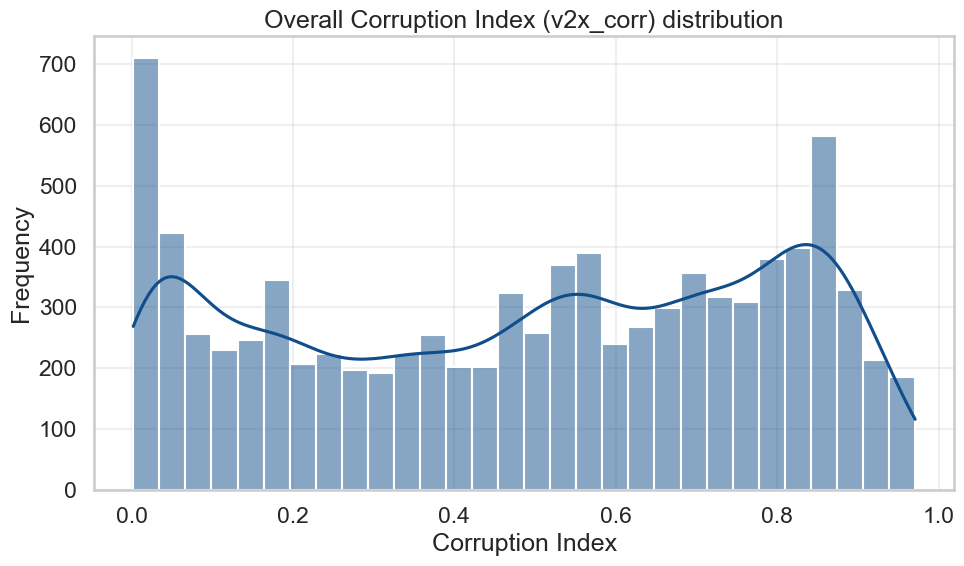

In [ ]:
bins = 30 
plt.figure(figsize=(10, 6))
sns.histplot(df_imputed['v2x_corr'].dropna(), kde=True, bins=bins, color="#104E8B")
plt.title('Overall Corruption Index (v2x_corr) distribution')
plt.xlabel('Corruption Index')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show() 

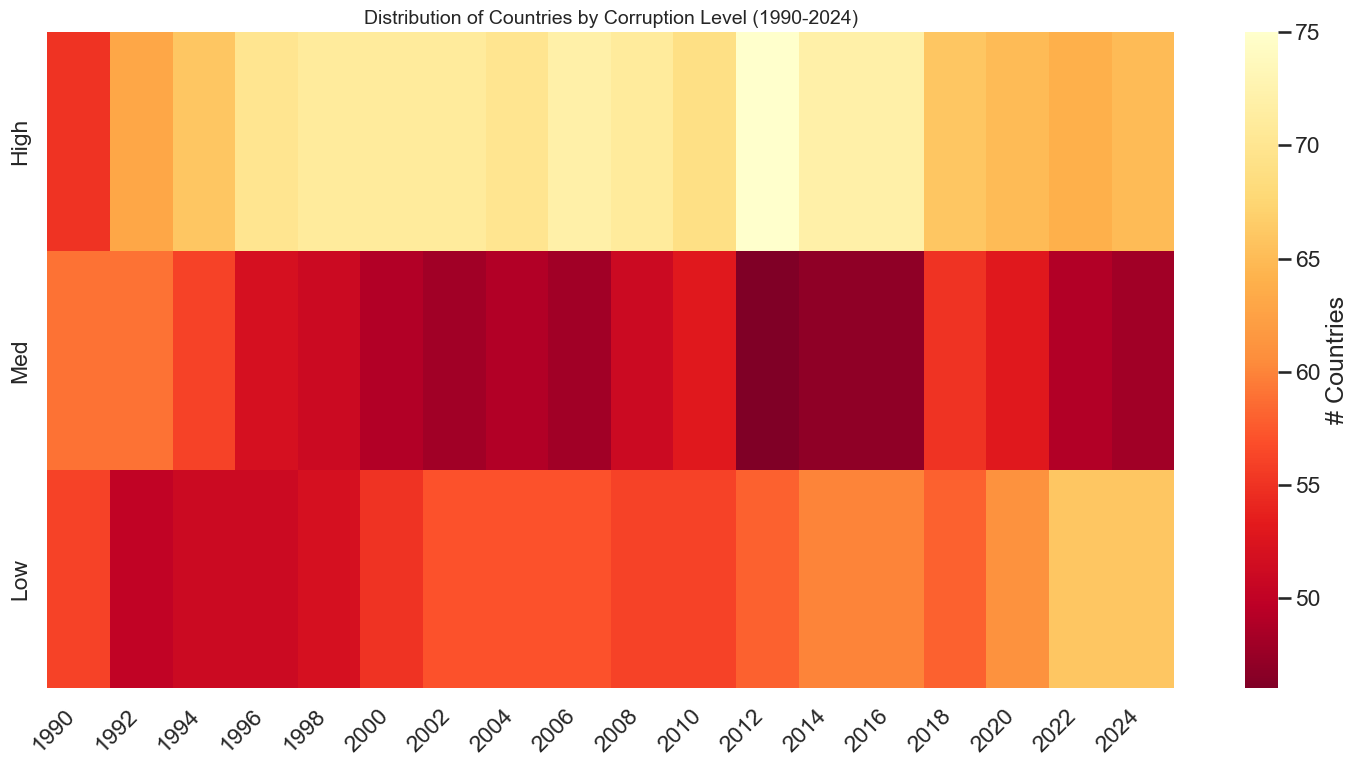

In [ ]:
# Define corruption level categories based on v2x_corr values 

bins = [0, 0.33, 0.66, 1.0]
labels = ['Low', 'Med', 'High']

# Filter data from 1990 to 2024
df_filtered = df_imputed[(df_imputed['year'] >= 1990) & (df_imputed['year'] <= 2024)].copy()

# Create the corruption level category
df_filtered['corruption_level'] = pd.cut(df_imputed['v2x_corr'], bins=bins, labels=labels)

# Create a pivot table counting countries in each corruption level per year
heatmap_data = pd.crosstab(df_filtered['corruption_level'], df_filtered['year'])

# Reorder the index to have High at top, Med in middle, Low at bottom
heatmap_data = heatmap_data.reindex(['High', 'Med', 'Low'])

# Keep only every 2 years
years_to_keep = list(range(1990, 2025, 2))
heatmap_data = heatmap_data.loc[:, heatmap_data.columns.isin(years_to_keep)]

# Create the heatmap visualization
plt.figure(figsize=(15, 8))
ax = sns.heatmap(
    heatmap_data, 
    cmap="YlOrRd_r",
    annot=False,    # Don't show count values in cells
    cbar_kws={'label': '# Countries'}
)

plt.title('Distribution of Countries by Corruption Level (1990-2024)', fontsize=14)
ax.set_ylabel('')
ax.set_xlabel('')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Top 10 positively correlated features with v2x_corr:
e_v2x_corr_5C: 0.9809
v2xnp_regcorr: 0.9804
e_v2x_corr_4C: 0.9712
v2x_execorr: 0.9436
v2x_pubcorr: 0.9412
e_v2x_corr_3C: 0.9308
e_v2x_execorr_5C: 0.9252
e_v2x_pubcorr_5C: 0.9221
e_v2x_execorr_4C: 0.9136
e_v2x_pubcorr_4C: 0.9059

Top 10 negatively correlated features with v2x_corr:
v2exbribe: -0.9110
v2excrptps: -0.9126
v2xel_frefair_imputed: nan
v2xdl_delib_imputed: nan
e_v2xdl_delib_4C_imputed: nan
e_v2xdl_delib_5C_imputed: nan
e_v2xel_frefair_3C_imputed: nan
e_v2xel_frefair_4C_imputed: nan
e_v2xel_frefair_5C_imputed: nan
elections_permitted: nan


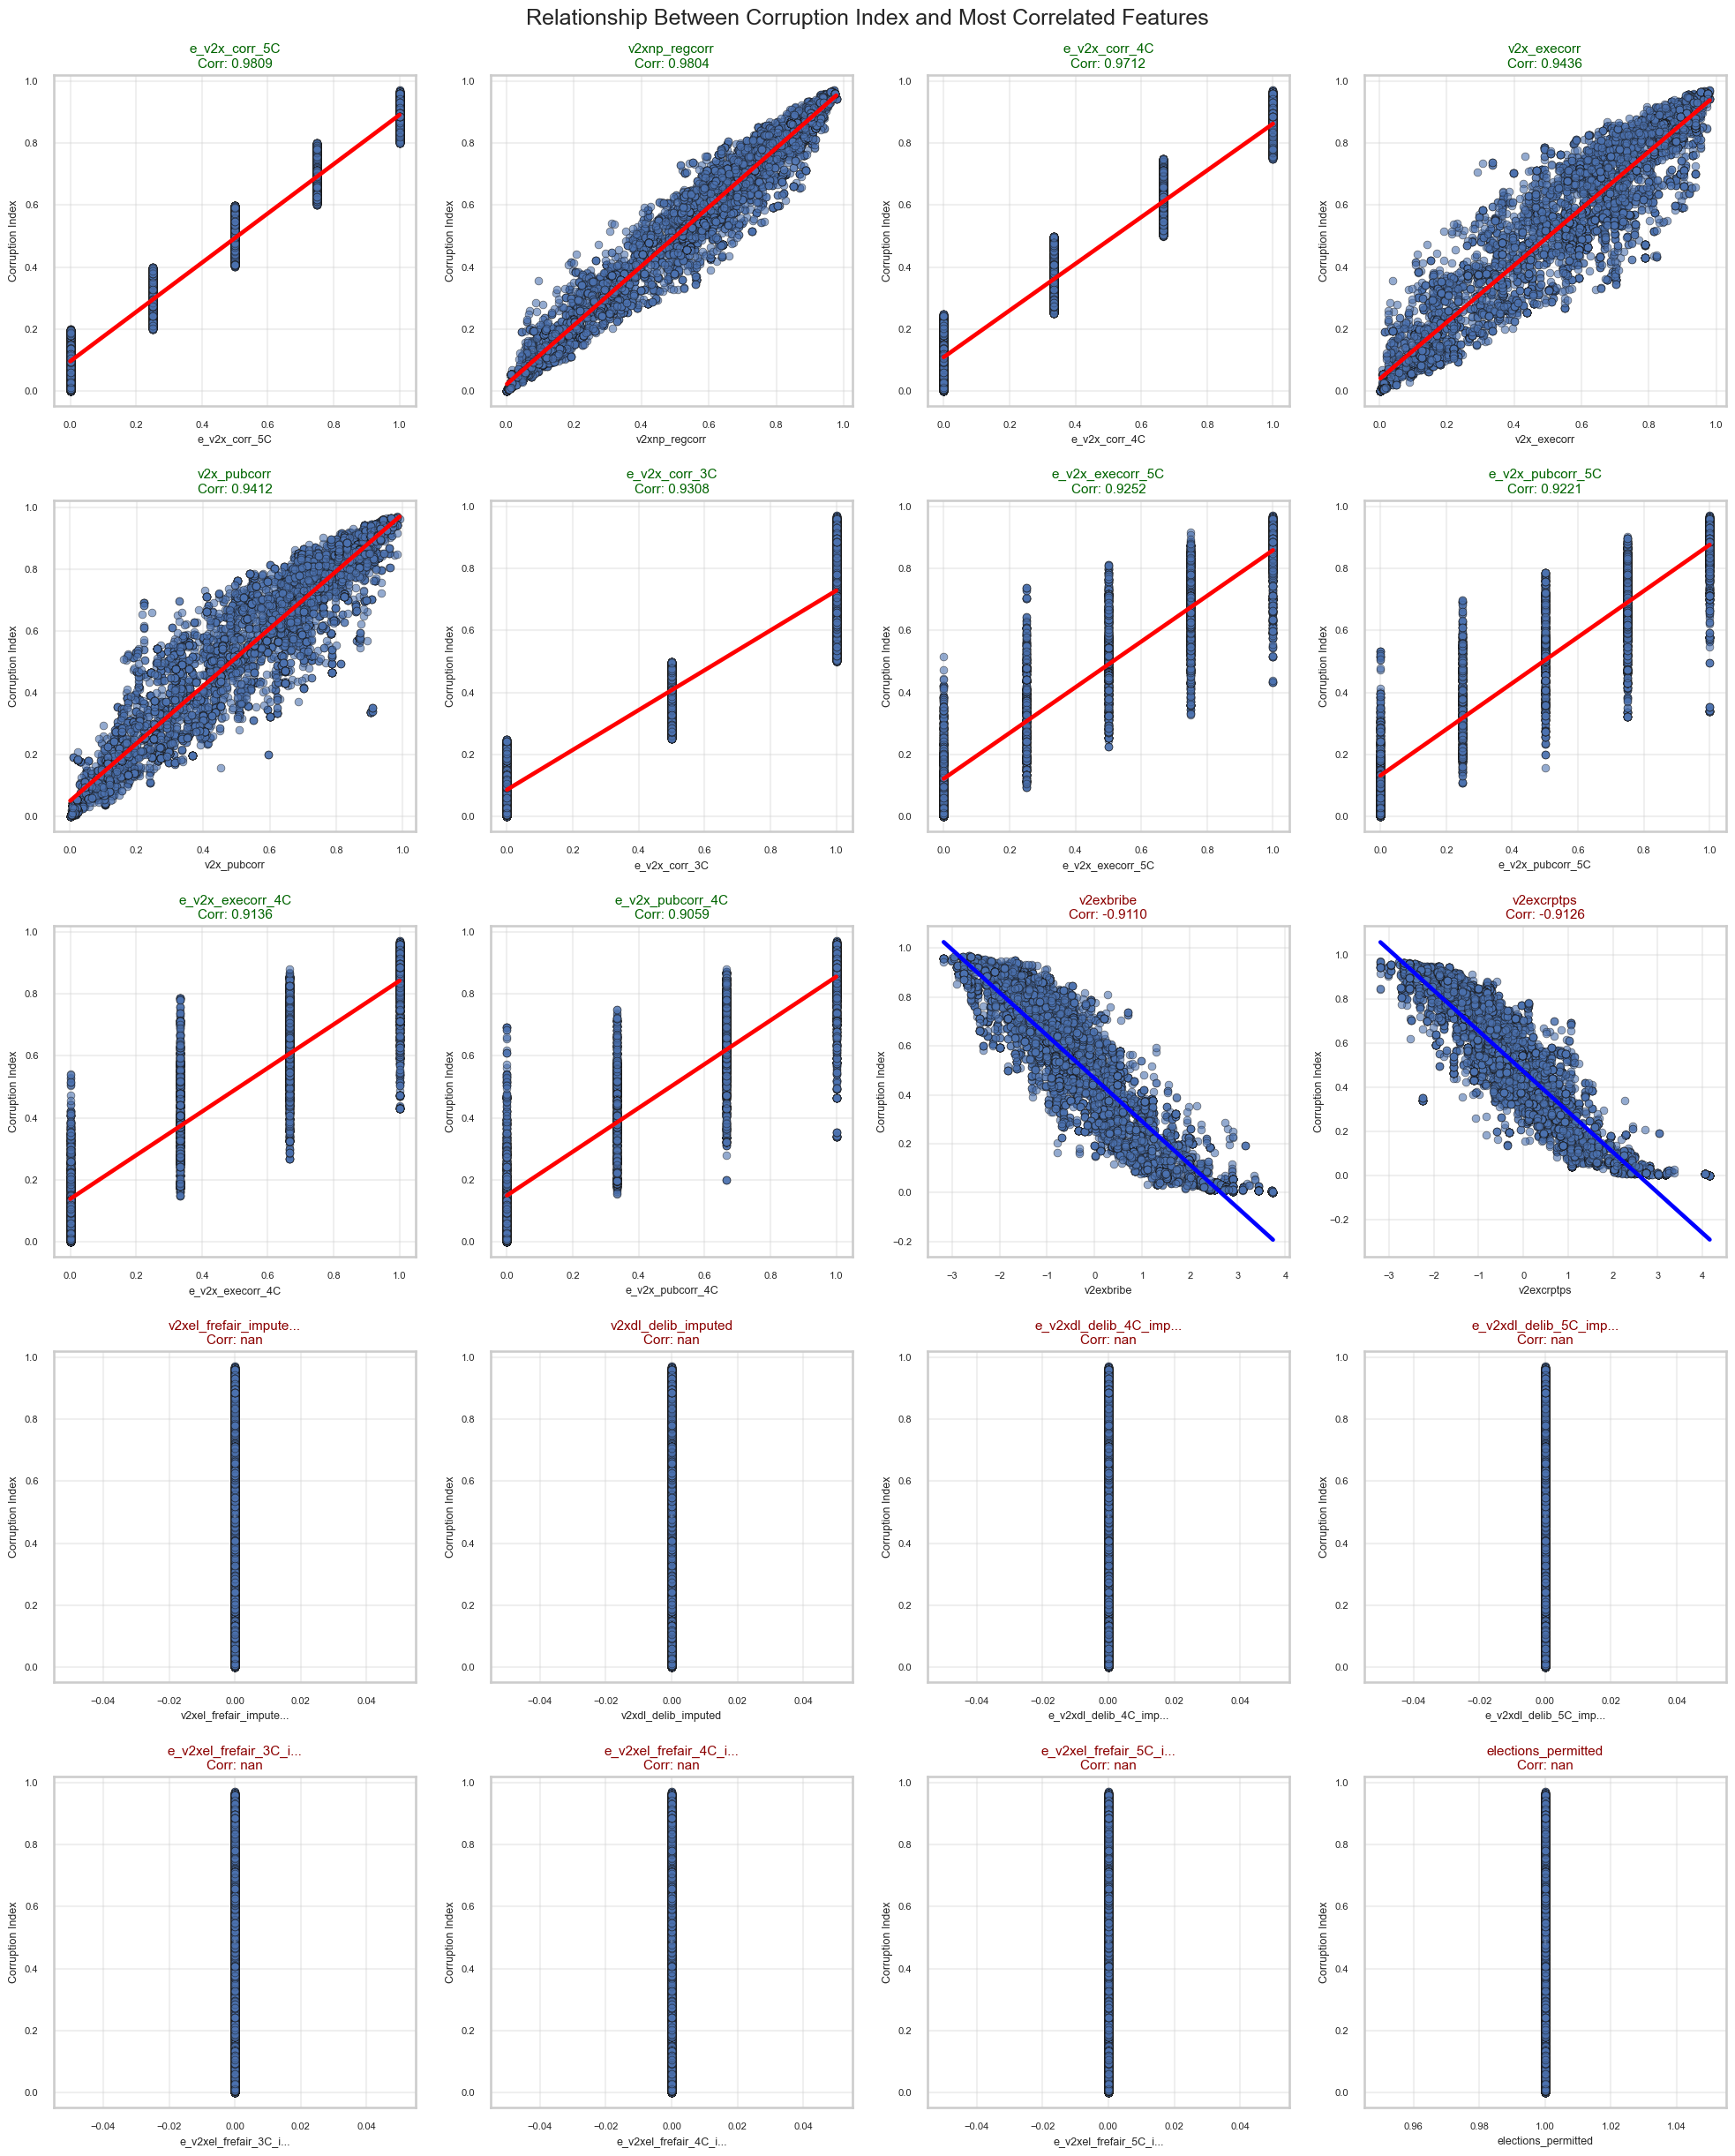

In [ ]:
# First, select only numeric columns 

numeric_cols = df_imputed.select_dtypes(include=['float64', 'int64']).columns

# Calculate correlations with v2x_corr (without taking absolute values)
correlations = df_imputed[numeric_cols].corr()['v2x_corr'].sort_values(ascending=False)

# Get top 10 positively correlated features (excluding v2x_corr itself)
top_pos_features = correlations[1:11].index.tolist()  # Exclude v2x_corr itself

# Get top 10 negatively correlated features
top_neg_features = correlations.tail(10).index.tolist()

# Combine positive and negative features
top_features = top_pos_features + top_neg_features

# Print the correlation values for reference
print("Top 10 positively correlated features with v2x_corr:")
for feature in top_pos_features:
    corr_value = df_imputed[['v2x_corr', feature]].corr().iloc[0, 1]
    print(f"{feature}: {corr_value:.4f}")

print("\nTop 10 negatively correlated features with v2x_corr:")
for feature in top_neg_features:
    corr_value = df_imputed[['v2x_corr', feature]].corr().iloc[0, 1]
    print(f"{feature}: {corr_value:.4f}")

# Create a grid of scatter plots
fig, axes = plt.subplots(5, 4, figsize=(20, 25))
axes = axes.flatten()

# Create scatter plots - one for each feature vs v2x_corr
for i, feature in enumerate(top_features):
    sns.scatterplot(
        data=df_imputed,
        x=feature,
        y='v2x_corr',
        alpha=0.6,
        s=40,
        edgecolor='k',
        linewidth=0.5,
        ax=axes[i]
    )
    
    # Add a regression line
    sns.regplot(
        data=df_imputed,
        x=feature,
        y='v2x_corr',
        scatter=False,
        ax=axes[i],
        line_kws={'color': 'red' if i < 10 else 'blue'}  # Red for positive, blue for negative
    )
    
    # Calculate and display correlation on the plot
    corr = df_imputed[[feature, 'v2x_corr']].corr().iloc[0, 1]
    
    # Create a more concise feature name for display
    feature_name = feature[:20] + '...' if len(feature) > 20 else feature
    
    # Color the title based on correlation direction
    title_color = 'darkgreen' if i < 10 else 'darkred'
    
    axes[i].set_title(f'{feature_name}\nCorr: {corr:.4f}', fontsize=11, color=title_color)
    axes[i].set_xlabel(feature_name, fontsize=9)
    axes[i].set_ylabel('Corruption Index', fontsize=9)
    axes[i].grid(True, alpha=0.3)
    
    # Adjust tick label size
    axes[i].tick_params(axis='both', which='major', labelsize=8)

plt.suptitle('Relationship Between Corruption Index and Most Correlated Features', fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

In [ ]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

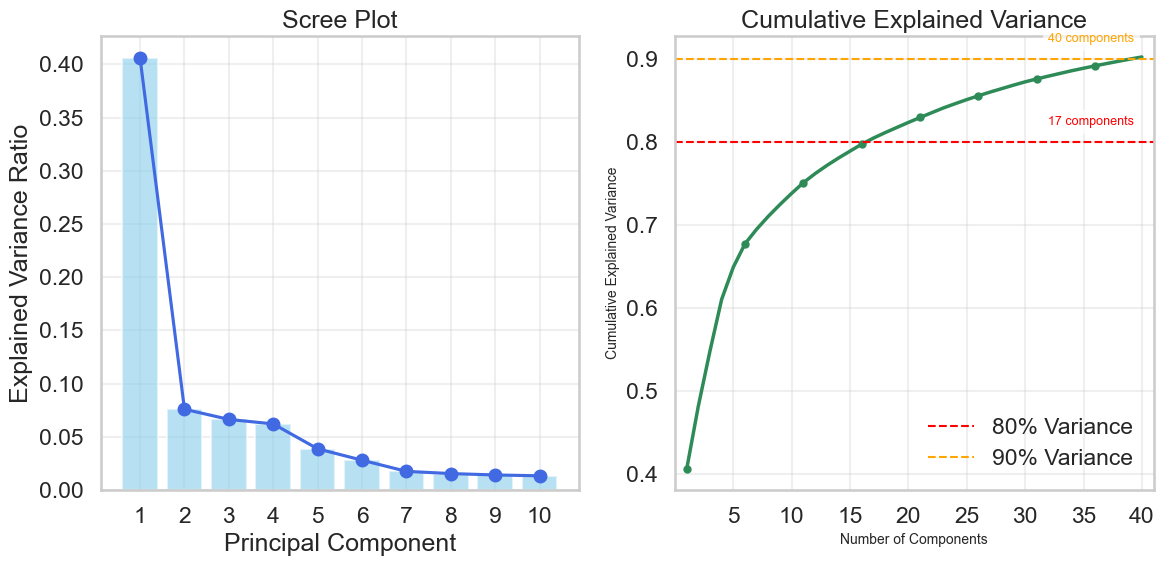

Components needed for 80% variance: 17
Components needed for 90% variance: 40
PC1 explains 0.4060 (40.60%) of variance
PC2 explains 0.0760 (7.60%) of variance
PC3 explains 0.0664 (6.64%) of variance
PC4 explains 0.0622 (6.22%) of variance
PC5 explains 0.0388 (3.88%) of variance
First 2 PCs together explain 0.4820 (48.20%) of variance
First 3 PCs together explain 0.5484 (54.84%) of variance


In [ ]:
# Separate identifier columns from numeric data     
id_columns = ['country_name', 'country_id', 'country_text_id', 'year'] 
feature_cols = [col for col in df_imputed.columns if col not in id_columns]  

# Extract numeric data for PCA 
X = df_imputed[feature_cols].values  

# Standardize the data 
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X)  

# Perform PCA 
pca = PCA() 
pca_result = pca.fit_transform(X_scaled)  

# Create a DataFrame with PCA results 
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])  

# Add identifiers back to the PCA results 
pca_df = pd.concat([pca_df, df_imputed[id_columns].reset_index(drop=True)], axis=1)  

# 1. SCREE PLOT - Plot explained variance 
plt.figure(figsize=(12, 6))  

# Individual explained variance 
plt.subplot(1, 2, 1) 
plt.bar(range(1, 11), pca.explained_variance_ratio_[:10], alpha=0.6, color='skyblue') 
plt.plot(range(1, 11), pca.explained_variance_ratio_[:10], 'o-', color='royalblue') 
plt.xlabel('Principal Component') 
plt.ylabel('Explained Variance Ratio') 
plt.title('Scree Plot') 
plt.xticks(range(1, 11)) 
plt.grid(alpha=0.3)  

# FINAL VERSION: Cumulative explained variance - no vertical lines, x-axis up to 40
plt.subplot(1, 2, 2) 
cumulative_variance = np.cumsum(pca.explained_variance_ratio_) 

# Find components for thresholds
n_components_80 = np.argmax(cumulative_variance >= 0.8) + 1 
n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1

# Fixed display of 40 components as requested
max_comp_to_show = 40

# Plot cumulative variance
plt.plot(
    range(1, min(max_comp_to_show + 1, len(cumulative_variance) + 1)), 
    cumulative_variance[:max_comp_to_show], 
    'o-', 
    color='seagreen',
    linewidth=2.5,
    markersize=5,
    markevery=5  # Only show markers every 5 points
)

# Add threshold lines with better styling
plt.axhline(y=0.8, color='red', linestyle='--', linewidth=1.5, label='80% Variance')
plt.axhline(y=0.9, color='orange', linestyle='--', linewidth=1.5, label='90% Variance')

# Annotate threshold points without arrows or vertical lines
plt.text(
    max_comp_to_show * 0.8,  # Position at 80% of the x-axis
    0.82,                    # Just above the 80% line
    f'{n_components_80} components',
    color='red',
    fontsize=9,
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
)

plt.text(
    max_comp_to_show * 0.8,  # Position at 80% of the x-axis
    0.92,                    # Just above the 90% line
    f'{n_components_90} components',
    color='orange',
    fontsize=9,
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
)

# Set x-axis ticks at intervals of 5
plt.xticks(range(5, max_comp_to_show + 1, 5))

# Set x-axis limits explicitly
plt.xlim(0, max_comp_to_show + 1)

plt.xlabel('Number of Components', fontsize=10)
plt.ylabel('Cumulative Explained Variance', fontsize=10)
plt.title('Cumulative Explained Variance')
plt.grid(alpha=0.3)
plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig('pca_scree_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate number of components for variance thresholds 

print(f"Components needed for 80% variance: {n_components_80}")
print(f"Components needed for 90% variance: {n_components_90}")

# Print variance explained by first few components   
for i, var in enumerate(pca.explained_variance_ratio_[:5]):
    print(f"PC{i+1} explains {var:.4f} ({var*100:.2f}%) of variance")
print(f"First 2 PCs together explain {sum(pca.explained_variance_ratio_[:2]):.4f} ({sum(pca.explained_variance_ratio_[:2])*100:.2f}%) of variance")
print(f"First 3 PCs together explain {sum(pca.explained_variance_ratio_[:3]):.4f} ({sum(pca.explained_variance_ratio_[:3])*100:.2f}%) of variance")

In [ ]:
pca_df.head(3)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC354,PC355,PC356,PC357,PC358,PC359,country_name,country_id,country_text_id,year
0,-10.195671,-1.286158,1.999865,-0.248546,-4.497008,-2.290876,-0.407368,-0.701028,2.652400,-1.836283,...,-4.557590e-14,8.661798e-15,5.198265e-15,-1.974128e-14,5.872659e-14,4.611678e-14,Mexico,3,MEX,1971
1,-10.058072,-2.025377,1.800817,-0.295716,-4.697324,-2.658664,0.629683,-0.778642,0.683164,-0.605818,...,-2.703201e-14,2.151195e-14,2.699443e-14,-1.247152e-14,7.038320e-14,3.038591e-14,Mexico,3,MEX,1972
2,-10.013840,-2.025977,1.790257,-0.293739,-4.697446,-2.691865,0.645513,-0.789090,0.696893,-0.606352,...,-3.003547e-14,2.320110e-14,2.381466e-14,-1.090082e-14,6.729024e-14,5.172715e-14,Mexico,3,MEX,1973


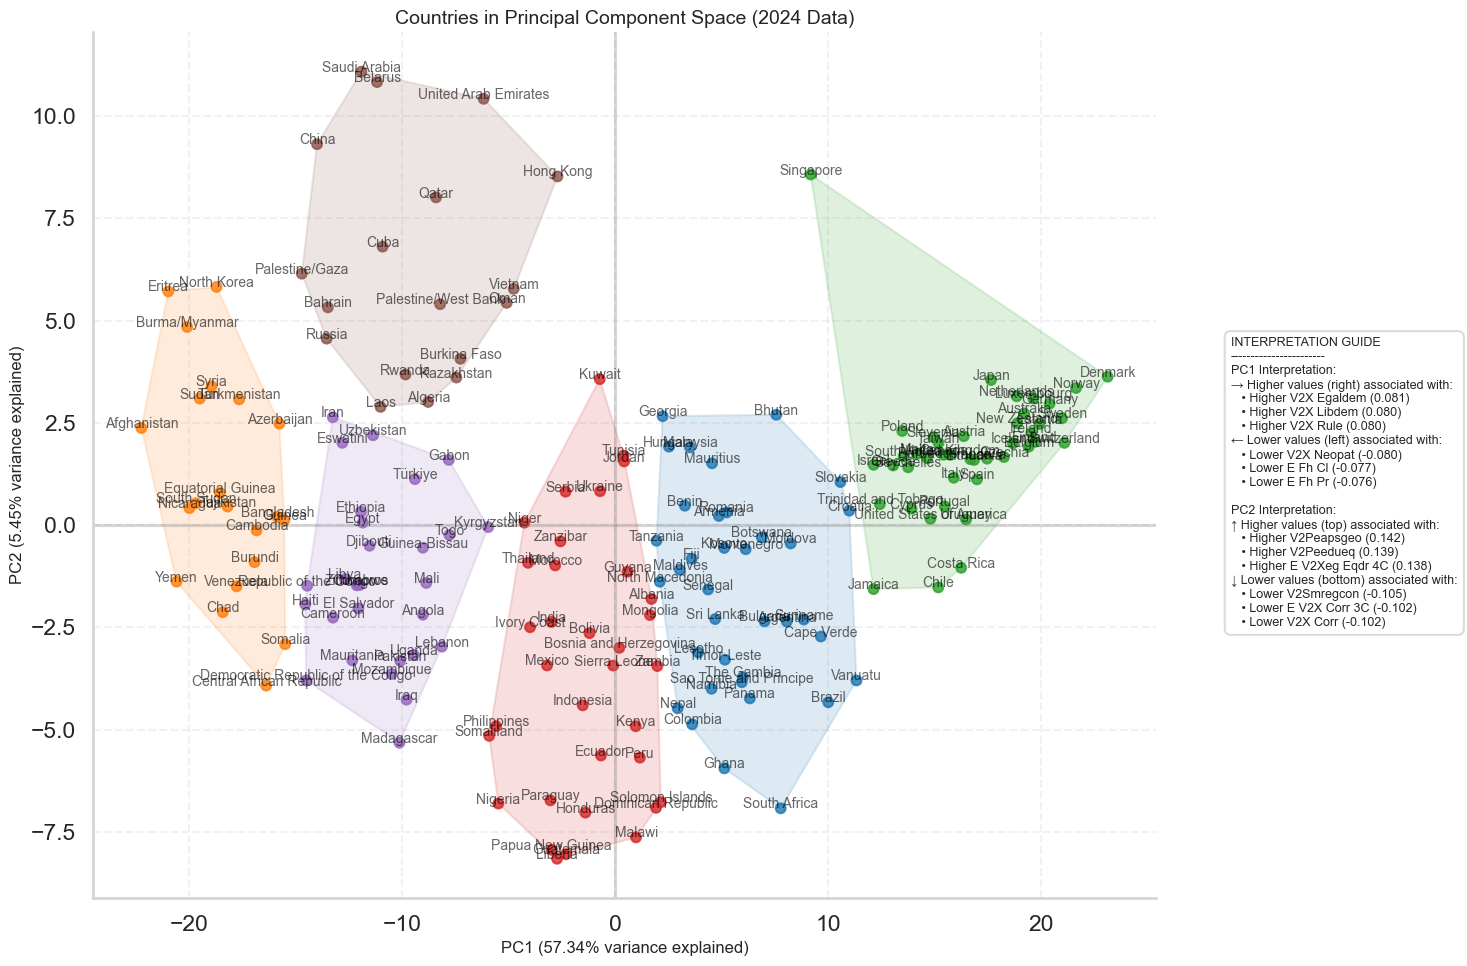

Top features contributing to PC1:
v2x_egaldem         0.080574
v2x_libdem          0.080206
v2x_neopat          0.079681
v2x_rule            0.079515
e_wbgi_vae          0.079434
v2x_delibdem        0.078604
v2x_liberal         0.078277
e_v2x_egaldem_5C    0.078126
e_fh_rol            0.078051
v2x_polyarchy       0.078043
dtype: float64

Top features contributing to PC2:
v2peapsgeo         0.141736
v2peedueq          0.138684
e_v2xeg_eqdr_4C    0.137934
e_v2xeg_eqdr_5C    0.133590
e_gdppc            0.131589
v2peapsecon        0.130033
v2xeg_eqdr         0.129850
v2lgcrrpt          0.129553
v2peapssoc         0.126013
v2pehealth         0.124635
dtype: float64

Cluster Analysis:

Cluster 1 countries: Suriname, Ghana, South Africa, Colombia, Brazil, Senegal, Argentina, Kosovo, Tanzania, Benin, Bhutan, Nepal, Botswana, Cape Verde, Timor-Leste, Lesotho, Maldives, Panama, Armenia, The Gambia, Georgia, Moldova, Namibia, Sri Lanka, Bulgaria, Croatia, Fiji, North Macedonia, Malaysia, Mauritiu

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.spatial import ConvexHull

# Assuming df_imputed is already loaded and PCA is performed
# First, filter for only 2024 data
df_2024 = df_imputed[df_imputed['year'] == 2024].copy()

# Perform PCA on 2024 data only
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Separate identifier columns from numeric data
id_columns = ['country_name', 'country_id', 'country_text_id', 'year'] 
feature_cols = [col for col in df_2024.columns if col not in id_columns]  

# Extract numeric data for PCA
X = df_2024[feature_cols].values  

# Standardize the data 
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X)  

# Perform PCA 
pca = PCA() 
pca_result = pca.fit_transform(X_scaled)  

# Create a DataFrame with PCA results 
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])  

# Add identifiers back to the PCA results 
pca_df = pd.concat([pca_df, df_2024[id_columns].reset_index(drop=True)], axis=1)

# Create a clean figure with white background, with extra space on the right for the guide
plt.figure(figsize=(16, 10), facecolor='white')
ax = plt.gca()
ax.set_facecolor('white')  # Change the panel background to white

# Determine the appropriate number of clusters based on dataset size
n_clusters = min(6, len(pca_df))  # Adjust based on how many countries you have in 2024
if len(pca_df) < 3:
    n_clusters = 1  # If very few points, don't cluster

# Define a function to draw the convex hull around clusters
def plot_convex_hull(points, ax, color, alpha=0.1):
    if len(points) < 3:
        return  # Need at least 3 points for a convex hull
    
    try:
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
        # Draw the polygon
        ax.fill(hull_points[:, 0], hull_points[:, 1], color=color, alpha=alpha)
    except Exception as e:
        # In case of errors (like colinear points), use an ellipse instead
        x_mean, y_mean = np.mean(points[:, 0]), np.mean(points[:, 1])
        x_std, y_std = np.std(points[:, 0]), np.std(points[:, 1])
        ellipse = Ellipse((x_mean, y_mean), width=x_std*4, height=y_std*4, 
                          fill=True, color=color, alpha=alpha)
        ax.add_patch(ellipse)

if n_clusters > 1:
    # Perform K-means clustering to help with visualization
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(pca_df[['PC1', 'PC2']])
    pca_df['Cluster'] = clusters

    # Custom color map with distinct colors
    colors = list(mcolors.TABLEAU_COLORS) + list(mcolors.CSS4_COLORS)[:n_clusters]
    cmap = {i: colors[i] for i in range(n_clusters)}

    # First plot the convex hulls/ellipses for each cluster
    for cluster in range(n_clusters):
        cluster_data = pca_df[pca_df['Cluster'] == cluster]
        
        # Draw the convex hull or ellipse for this cluster
        if len(cluster_data) >= 3:  # Need at least 3 points for a polygon
            cluster_points = cluster_data[['PC1', 'PC2']].values
            plot_convex_hull(cluster_points, ax, cmap[cluster], alpha=0.15)
        elif len(cluster_data) > 0:  # If only 1-2 points, use a circle
            center = cluster_data[['PC1', 'PC2']].mean()
            circle = plt.Circle((center['PC1'], center['PC2']), 0.5, 
                               color=cmap[cluster], alpha=0.15)
            ax.add_patch(circle)

    # Then plot the points on top of the hulls WITHOUT adding them to the legend
    for cluster in range(n_clusters):
        cluster_data = pca_df[pca_df['Cluster'] == cluster]
        plt.scatter(
            cluster_data['PC1'], 
            cluster_data['PC2'],
            c=[cmap[cluster]] * len(cluster_data),
            s=50,  # Smaller circle size
            alpha=0.8,
            label=None  # No label means won't appear in legend
        )
else:
    # If only one cluster, use a simple scatter plot
    plt.scatter(
        pca_df['PC1'], 
        pca_df['PC2'],
        c='tab:blue',
        s=50,  # Smaller circle size
        alpha=0.8
    )
    
    # Add a single ellipse for the whole dataset
    if len(pca_df) >= 3:
        all_points = pca_df[['PC1', 'PC2']].values
        plot_convex_hull(all_points, ax, 'tab:blue', alpha=0.15)

# Initial positions for labels
label_positions = []
for i, row in pca_df.iterrows():
    # Default position is to the right of the point
    label_positions.append((row['PC1'] + 0.1, row['PC2']))

# Simple iterative adjustment to prevent overlap (basic algorithm)
def adjust_positions(positions, iterations=50):
    adjusted = positions.copy()
    for _ in range(iterations):
        for i in range(len(adjusted)):
            for j in range(len(adjusted)):
                if i != j:
                    # Calculate distance between labels
                    dist = np.sqrt((adjusted[i][0] - adjusted[j][0])**2 + 
                                  (adjusted[i][1] - adjusted[j][1])**2)
                    # If too close, adjust positions
                    if dist < 0.5:  # Threshold distance
                        # Direction vector from j to i
                        dx = adjusted[i][0] - adjusted[j][0]
                        dy = adjusted[i][1] - adjusted[j][1]
                        # Normalize
                        length = max(0.0001, np.sqrt(dx**2 + dy**2))
                        dx, dy = dx/length, dy/length
                        # Move i away from j
                        adjusted[i] = (adjusted[i][0] + 0.1*dx, adjusted[i][1] + 0.1*dy)
    return adjusted

# Adjust label positions to prevent overlap
adjusted_positions = adjust_positions(label_positions)

# Add labels with adjusted positions - no boxes and lighter font (60% opacity)
for i, row in pca_df.iterrows():
    plt.annotate(
        row['country_name'],  # Just country name without year since all are 2024
        (row['PC1'], row['PC2']),
        xytext=(adjusted_positions[i][0] - row['PC1'], adjusted_positions[i][1] - row['PC2']),
        textcoords='offset points',
        fontsize=10,
        ha='center',
        color='black',
        alpha=0.6,  # 60% opacity for the text
        bbox=None   # No box around the label
    )

# Add axis labels with variance explained percentages
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance explained)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance explained)', fontsize=12)
plt.title('Countries in Principal Component Space (2024 Data)', fontsize=14)

# Add light grid and reference lines
plt.grid(color='lightgray', linestyle='--', alpha=0.3)
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='gray', linestyle='-', alpha=0.3)

# Remove the top and right spines for a cleaner look 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('lightgray')
ax.spines['bottom'].set_color('lightgray')

# Calculate feature importance for interpretation guide 

pc1_loadings = pd.Series(pca.components_[0], index=feature_cols)
pc2_loadings = pd.Series(pca.components_[1], index=feature_cols)

top_pc1_positive = pc1_loadings.sort_values(ascending=False).head(3)
top_pc1_negative = pc1_loadings.sort_values().head(3)
top_pc2_positive = pc2_loadings.sort_values(ascending=False).head(3)
top_pc2_negative = pc2_loadings.sort_values().head(3)

# Add interpretation guide as a text box on the right side of the plot 

interpretation_text = [
    "INTERPRETATION GUIDE",
    "-----------------------",
    "PC1 Interpretation:",
    "→ Higher values (right) associated with:",
]

# Add top positive PC1 features
for name, value in top_pc1_positive.items():
    simplified_name = name.replace('_', ' ').title()
    interpretation_text.append(f"   • Higher {simplified_name[:25]} ({value:.3f})")

interpretation_text.extend([
    "← Lower values (left) associated with:"
])

# Add top negative PC1 features
for name, value in top_pc1_negative.items():
    simplified_name = name.replace('_', ' ').title()
    interpretation_text.append(f"   • Lower {simplified_name[:25]} ({value:.3f})")

interpretation_text.extend([
    "",
    "PC2 Interpretation:",
    "↑ Higher values (top) associated with:"
])

# Add top positive PC2 features
for name, value in top_pc2_positive.items():
    simplified_name = name.replace('_', ' ').title()
    interpretation_text.append(f"   • Higher {simplified_name[:25]} ({value:.3f})")

interpretation_text.extend([
    "↓ Lower values (bottom) associated with:"
])

# Add top negative PC2 features
for name, value in top_pc2_negative.items():
    simplified_name = name.replace('_', ' ').title()
    interpretation_text.append(f"   • Lower {simplified_name[:25]} ({value:.3f})")

# Add the interpretation text box
plt.figtext(
    0.78, 0.5,  # Position at the right side of the figure
    "\n".join(interpretation_text),
    fontsize=9,
    verticalalignment='center',
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='lightgray', alpha=0.8)
)

plt.tight_layout(rect=[0, 0, 0.75, 1])  # Adjust the main plot to leave room for the guide
plt.savefig('pca_2024_final.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Print information about what the PCs represent
print("Top features contributing to PC1:")
pc1_loadings = pd.Series(pca.components_[0], index=feature_cols)
print(pc1_loadings.abs().sort_values(ascending=False).head(10))

print("\nTop features contributing to PC2:")
pc2_loadings = pd.Series(pca.components_[1], index=feature_cols)
print(pc2_loadings.abs().sort_values(ascending=False).head(10))

# Analyze clusters if we have them
if n_clusters > 1:
    print("\nCluster Analysis:")
    for cluster in range(n_clusters):
        countries = pca_df[pca_df['Cluster'] == cluster]['country_name'].tolist()
        print(f"\nCluster {cluster+1} countries: {', '.join(countries)}")

1. Regression-based Models:-    

Ridge Regression (L2 regularization) 
Lasso Regression (L1 regularization) 

2. Tree-based Models:-   

Decision Tree Regression
Random Forest Regression
Gradient Boosting Regression (XGBoost)

3. Support Vector Machines:- 

Support Vector Regression (SVR)
Linear SVR
Kernel SVR (with different kernels like RBF, polynomial)

4. Neural Network Approaches:-  
 
Multi-layer Perceptron Regression
Deep Neural Networks 

Compare model performance using metrics like:- 
R-squared
Mean Squared Error
Mean Absolute Error
Cross-validation scores